<a href="https://colab.research.google.com/github/baochi0212/facemask/blob/master/My_YOLOV5_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The prev facemask use the retina net(pyramid)

In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10902, done.
remote: Total 10902 (delta 0), reused 0 (delta 0), pack-reused 10902
Receiving objects: 100% (10902/10902), 10.95 MiB | 25.20 MiB/s, done.
Resolving deltas: 100% (7537/7537), done.


In [2]:
!pip install -r /content/yolov5/requirements.txt

     |████████████████████████████████| 596 kB 5.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 9), reused 18 (delta 5), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [4]:
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Face Mask Detection.zip is done!


In [ ]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import os

def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)
        
        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)

        # change to tensor
        img = to_tensor(img)


        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset('images/')
test_dataset = MaskDataset('test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)


In [ ]:
a = [[1,2,3], [4,5,6]]
print(list(zip(*a)))
#* take a as combination of list zip(a, b) not zip(a)

[(1, 4), (2, 5), (3, 6)]


In [ ]:
iter(data_loader).next()[1][0], iter(data_loader).next()[0][0].shape
#format: data - label(boxes, labels(binary))
#different size so we have to pass the custom collate_fn

({'boxes': tensor([[ 79., 105., 109., 142.],
          [185., 100., 226., 144.],
          [325.,  90., 360., 141.]]), 'labels': tensor([0, 1, 0])},
 torch.Size([3, 366, 512]))

In [ ]:
dataset[1][0].shape, dataset[0][0]

(torch.Size([3, 156, 400]),
 tensor([[[0.4431, 0.4314, 0.3843,  ..., 0.1569, 0.2824, 0.3373],
          [0.4118, 0.3882, 0.3451,  ..., 0.1529, 0.1882, 0.3098],
          [0.3765, 0.3569, 0.3255,  ..., 0.1490, 0.1216, 0.2784],
          ...,
          [0.3333, 0.3412, 0.3569,  ..., 0.1098, 0.1098, 0.1137],
          [0.3373, 0.3490, 0.3608,  ..., 0.1137, 0.1137, 0.1176],
          [0.3647, 0.3765, 0.3922,  ..., 0.1176, 0.1176, 0.1216]],
 
         [[0.4353, 0.4235, 0.3765,  ..., 0.2314, 0.3843, 0.4549],
          [0.3922, 0.3804, 0.3373,  ..., 0.2275, 0.2863, 0.4275],
          [0.3608, 0.3412, 0.3098,  ..., 0.2235, 0.2235, 0.3922],
          ...,
          [0.3255, 0.3333, 0.3490,  ..., 0.1059, 0.1059, 0.1098],
          [0.3294, 0.3412, 0.3529,  ..., 0.1098, 0.1098, 0.1137],
          [0.3569, 0.3686, 0.3843,  ..., 0.1137, 0.1137, 0.1176]],
 
         [[0.4549, 0.4431, 0.3961,  ..., 0.4000, 0.6157, 0.7294],
          [0.4157, 0.3922, 0.3490,  ..., 0.3843, 0.5059, 0.6784],
          [0

Use roboflow to convert to yolov5 coco


In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [6]:
!pip install roboflow
%cd yolov5
from roboflow import Roboflow
rf = Roboflow(api_key="QlPOQtcxpcmV25dVhFGb")
project = rf.workspace().project("face_mask-oxref")
dataset = project.version(1).download("yolov5")

  Using cached roboflow-0.2.2-py3-none-any.whl (24 kB)
  Using cached chardet-4.0.0-py2.py3-none-any.whl (178 kB)
  Using cached python_dotenv-0.19.2-py2.py3-none-any.whl (17 kB)
  Using cached certifi-2021.5.30-py2.py3-none-any.whl (145 kB)
  Using cached wget-3.2-py3-none-any.whl
  Using cached kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl (1.1 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Attempting uninstall: kiwisolver
    Found existing installation: kiwisolver 1.3.2
    Uninstalling kiwisolver-1.3.2:
      Successfully uninstalled kiwisolver-1.3.2
  Attempting uninstall: cycler
    Found existing installation: cycler 0.11.0
    Uninstalling cycler-0.11.0:
      Successfully uninstalled cycler-0.11.0
  Attempting uninstall: certifi
    Found existing installation: certifi 2021.10.8
    Uninstalling certifi-2021.10.8:
      Successfully uninstalled certifi-2021.10.8
  Attempting uninstall: requests


/content/yolov5
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to face_mask-1 in yolov5pytorch:: 100%|██████████| 1708/1708 [00:01<00:00, 934.98it/s] 


In [3]:
#after restart the runtime:
%cd yolov5

/content/yolov5


In [4]:
#run yolo
!python train.py --img 416 --batch 16 --epochs 150 --data /content/yolov5/face_mask-1/data.yaml --weights /content/yolov5s.pt --cache

train: weights=/content/yolov5s.pt, cfg=, data=/content/yolov5/face_mask-1/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-243-g9c513ca torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, deg

In [5]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source /content/yolov5/face_mask-1/test/images

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/yolov5/face_mask-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-243-g9c513ca torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/85 /content/yolov5/face_mask-1/test/images/maksssksksss111_png.rf.a6c5c1da16624f479adf384126cc9590.jpg: 416x416 8 with_masks, 2 without_masks, Done. (0.028s)
image 2/85 /content/yolov5/face_mask-1/test/images/maksssksksss113_png.rf.e27a159aa9ea39278db92ef0bda23898.jpg: 416x416 3 with_masks, 1 without_mask, Done. (0.028s)
image 3/85 /content/yol

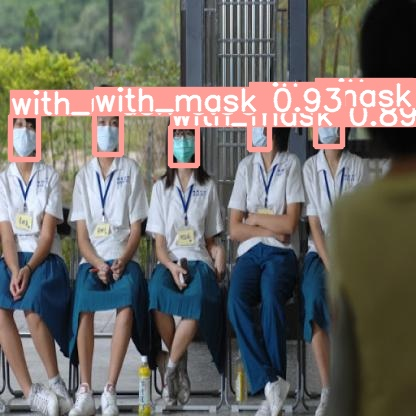

In [6]:
from glob import glob
from IPython.display import Image, display

for image in glob('/content/yolov5/runs/detect/exp/*.jpg'):
  display(Image(image))
  print()
  break
